In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as nnf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import math
import cv2
from tqdm import tqdm


workers = 0 if os.name == 'nt' else 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [2]:
# 범례 한글 깨짐 현상 해결
# https://ehpub.co.kr/47-matplotlib%EC%9D%98-rc%EC%97%90-%ED%95%9C%EA%B8%80-%ED%8F%B0%ED%8A%B8%EB%A5%BC-%EC%84%A4%EC%A0%95%ED%95%A0-%EC%88%98-%EC%9E%88%EC%96%B4%EC%9A%94/
# https://koosco.tistory.com/38
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [65]:
# data_path: 연예인 폴더들을 포함하는 상위 폴더
data_path = "/opt/ml/embedding_visualization/data/actor_data"

# embedding_saving_path: embedding vector 변수가 저장되는 파일 위치
embedding_saving_path = "/opt/ml/embedding_visualization/data/embedding.data"

# embedding_info_path: embedding vector에 해당하는 이미지 경로정보가 저장되는 파일 위치
embedding_info_path = "/opt/ml/embedding_visualization/data/embedding_info.data"

# resize_img_path : tensorboard에서 img visualization을 위해 사용하는 img가 저장되는 파일 위치
resize_img_path = "/opt/ml/embedding_visualization/data/resized_img.data"

In [4]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [5]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [22]:
# embeddings 로드
with open(embedding_saving_path, 'rb') as f:
    embeddings = pickle.load(f)

In [23]:
# path_infos 로드
with open(embedding_info_path, 'rb') as f:
    path_infos = pickle.load(f)

In [82]:
with open(resize_img_path, 'rb') as f:
    tensorboard_img = pickle.load(f)

In [38]:
print(np.shape(path_infos))

(19708, 2)


In [27]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/embedding_visualization')

2021-12-12 05:21:44.323416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/envs/lightweight/lib/python3.7/site-packages/cv2/../../lib64:
2021-12-12 05:21:44.323459: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [69]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [70]:
names = [name for name,file_name in path_infos]

In [72]:
print(np.shape(embeddings[:1000]))

(1000, 512)


In [105]:
tensorboard_embeddings = torch.tensor(embeddings[:400])
tensorboard_img = tensorboard_img[:400]
tensorboard_names = names[:400]

print(tensorboard_embeddings.shape)
print(tensorboard_img.shape)

torch.Size([400, 512])
torch.Size([400, 3, 50, 50])


In [107]:
writer.add_embedding(tensorboard_embeddings, # 400명 embedding 결과
                    metadata=tensorboard_names,
                    label_img=tensorboard_img,
                    global_step=None
                    )
writer.close()

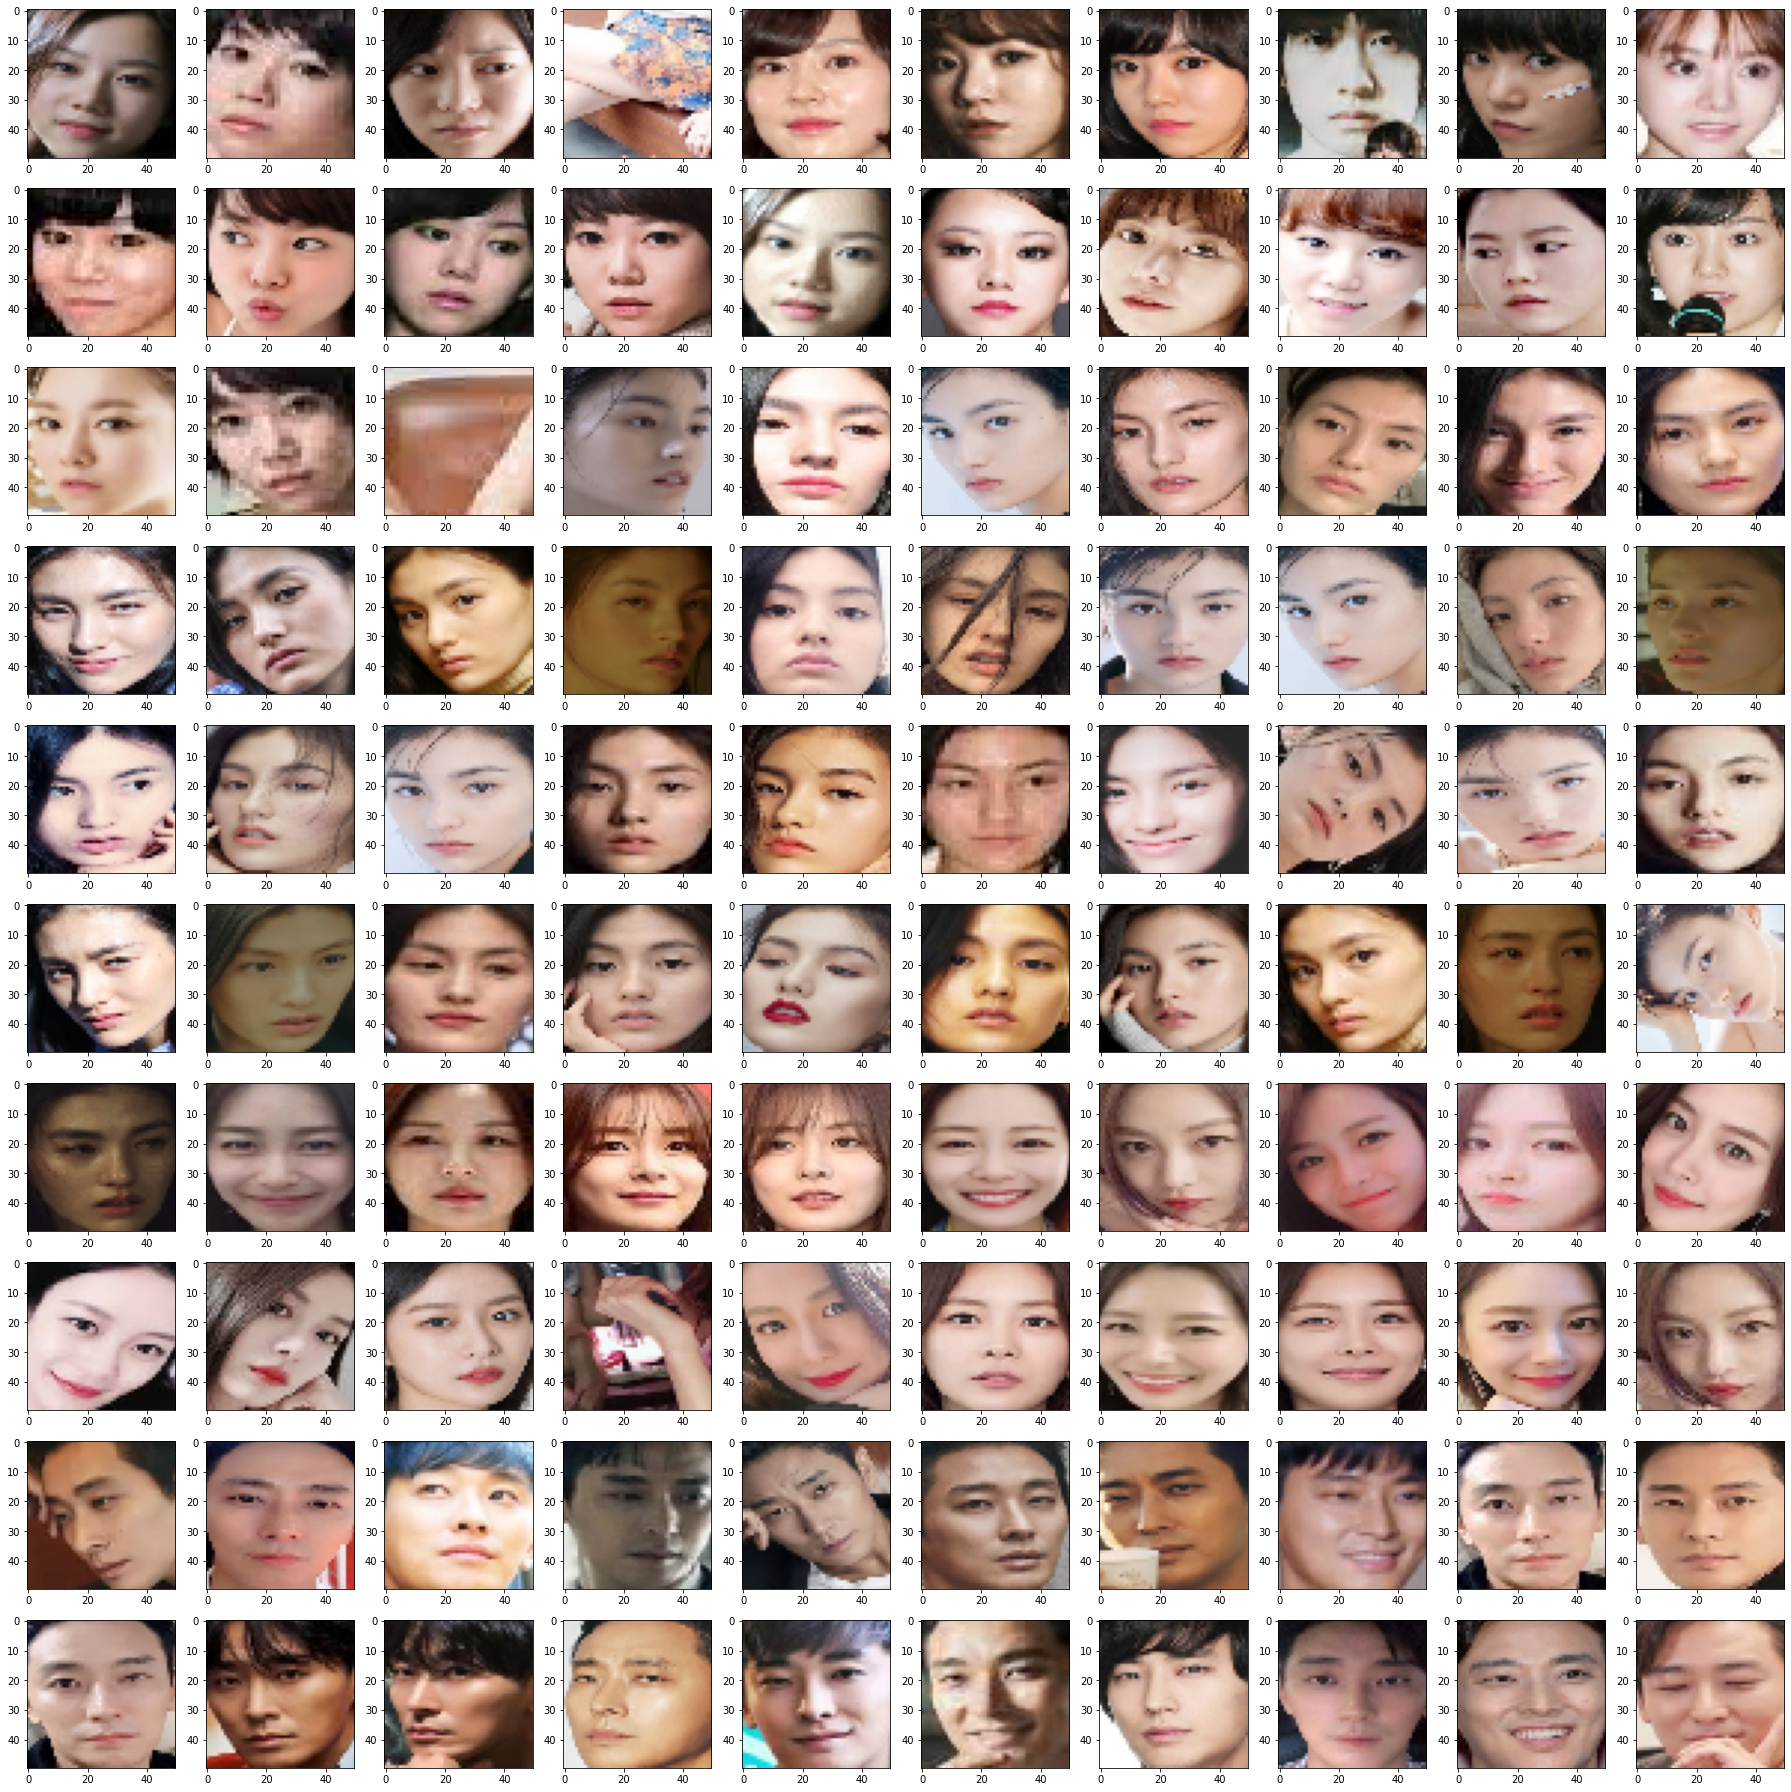

In [98]:
# crop된 face image 원본처럼 시각화 (MTCNN은 output을 normalize된 채로 output으로 내보냄!)
row_size = 10
col_size = min(10, math.ceil(len(tensorboard_img[:100])//row_size))
fig, ax = plt.subplots(row_size, col_size, figsize=(25, 25)) 
for i, output in enumerate(tensorboard_img[:100]):
    ax[i//row_size][i%col_size].imshow((output * 128 + 127.5).cpu().numpy().astype(np.Uint64).transpose((1,2,0)))

fig.tight_layout()
plt.show()